# Task 1: Does changing the bitrate (independent variable: 2000, 4000, 6000, 50000 kbps) have a significant effect on the video quality (VQ) ratings (dependent variable)? Please consider all ratings at a resolution of 1080p and framerate of 60fps for the FIRST game. Use the ratings provided in the gaming video quality dataset.

### Step 1: Import libraries and read in data set

In [1]:
# install.packages('dplyr')                                           # processing 
# install.packages('gdata')                                           # file reading
# install.packages('tidyverse')                                       # ggplot2 plot library
# install.packages('gridExtra')                                       # subplotting
# install.packages('stats')                                           # Friedman Test
# install.packages('rstatix')                                         # effect size for Friedman Test
# install.packages('coin', repos='http://R-Forge.R-project.org')      # effect size for Wilcoxon signed-rank post hoc

In [2]:
library(dplyr)     # processing
library(readxl)    # reading in data
library(stats)     # Friedman test
library(rstatix)   # effect size for Friedman Test
library(ggplot2)   # plots
library(gridExtra) # subplotting
library(coin)      # effect size for Wilcoxon signed-rank post hoc

Warning message:
"package 'dplyr' was built under R version 3.6.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'rstatix' was built under R version 3.6.2"
Attaching package: 'rstatix'

The following object is masked from 'package:stats':

    filter

Warning message:
"package 'gridExtra' was built under R version 3.6.2"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'coin' was built under R version 3.6.2"Loading required package: survival

Attaching package: 'coin'

The following objects are masked from 'package:rstatix':

    chisq_test, friedman_test, kruskal_test, sign_test, wilcox_test



In [3]:
# read in data sets

get_gaming_data <- function() {
    gaming_data <- read_excel("datasets/DB01_gaming_video_quality_dataset.xlsx")
    gaming_data <- gaming_data %>% dplyr::filter(Resolution == 1080, Framerate == 60, Game == 'Game1') %>%
                                    select(PID, Bitrate, VQ) %>%
                                    arrange(PID)
    
    gaming_data
}

gaming_data <- get_gaming_data()
head(gaming_data)

PID,Bitrate,VQ
1,2000,2.9
1,4000,2.0
1,6000,4.5
1,50000,4.6
2,2000,4.6
2,4000,4.7


### Step 2: Decide on which non-parametric test to use

#### => More than two groups (as 4 different bitrates) and each subject giving several ratings based on the bitrate condition => dependent ratings, one independent variable (bitrate) => Friedman Test

### Step 3: Check assumptions

#### 1. One group is measured more than 2 times => check, as each bitrate group contains 20+ ratings (each from a different subjects)
#### 2. Dependent variable (VQ) at least at ordinal level => check, as the video quality (VQ) ratings is continuous

#### => Assumptions for non-parametric Friedman Test met :)

### Step 4: Conduct Friedman Test

In [4]:
# Conduct Friedman Test

friedman.test(gaming_data$VQ, gaming_data$Bitrate, gaming_data$PID)


	Friedman rank sum test

data:  gaming_data$VQ, gaming_data$Bitrate and gaming_data$PID
Friedman chi-squared = 56.716, df = 3, p-value = 2.955e-12


In [5]:
# Compute effect size

friedman_effsize(gaming_data, VQ ~ Bitrate | PID)

.y.,n,effsize,method,magnitude
VQ,25,0.756214,Kendall W,large


#### Based on the Friedman Test, we can see that the p value is around 0, therefore we can assume that the bitrate has a significant impact on the video quality (VQ) ratings. The effect size is also of large magnitude. More: see interpretation

### Step 5: Pairwise comparison / post-hoc test

#### Two groups (bitrates) per pair and dependence between them because the subjects gave ratings for every bitrate => Wilcoxon signed-rank test as post-hoc test

#### Checking assumptions for Wilcoxon signed-rank test:
#### 1. Dependent variable at least ordinal (check, as VQ is contiuous)
#### 2. Two groups (check, as pairwise comparisons)
#### 3. Delta between groups with symmetric shape: don't know, let's look at the following plots!

In [6]:
# plotting all delta (= VQ_group_1 - VQ_group_2) distributions to check for symmetry

plot_deltas <- function(bitrate_combinations) {
    plots <- list()
    for (row in 1:nrow(bitrate_combinations)) {
        # setting up the data frame for the current pairwise comparison
        VQ1 <- (gaming_data %>% 
                filter(Bitrate == bitrate_combinations[row,][['Bitrate1']]) %>% 
                arrange(PID))[['VQ']]
        VQ2 <- (gaming_data %>% 
                filter(Bitrate == bitrate_combinations[row,][['Bitrate2']]) %>% 
                arrange(PID))[['VQ']]
        delta <- as.data.frame(VQ1 - VQ2)
        
        # save plot
        colnames(delta) <- c('Delta')
        plots[[row]] <- ggplot(delta, aes(x=Delta)) + 
          geom_histogram(color="red", fill="white", bins = 36) + 
            theme(panel.background = element_rect(fill = "lightblue", colour = "lightblue"), 
                  plot.title = element_text(size=10)) + 
                ggtitle(paste0('Delta distribution for ', 
                               bitrate_combinations[row,][['Bitrate2']], 
                               ' kbps and ', bitrate_combinations[row,][['Bitrate1']], ' kbps\nbitrate VQ ratings:'))
    }
    
    # plot all pairwise combination plots
    do.call(grid.arrange, plots)
}

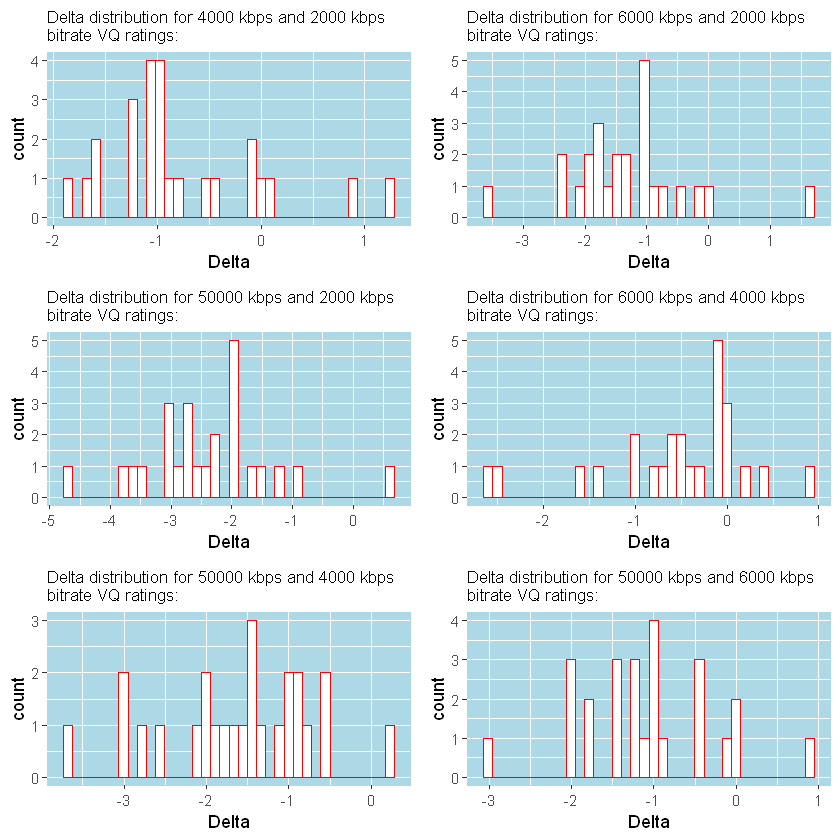

In [7]:
# finding all possible bitrate pairs without duplications

bitrates <- (gaming_data %>% distinct(Bitrate))[['Bitrate']]
all_bitrate_combinations <- expand.grid(bitrates, bitrates) %>% filter(Var1 != Var2) # remove self-comparisons
all_bitrate_combinations <- t(apply(all_bitrate_combinations, 1, sort)) # sort pairs
all_bitrate_combinations <- all_bitrate_combinations[!duplicated(all_bitrate_combinations),] # remove duplicates
colnames(all_bitrate_combinations) <- c('Bitrate1', 'Bitrate2') # add column names

plot_deltas(all_bitrate_combinations)

#### As we can see, the delta distributions is not perfectly symmetric, but we are still going to continue with the post-hoc test! :)

#### Conducting the post-hoc test

In [8]:
# Bonferroni correction to conservatively control Type I error

pairwise.wilcox.test(gaming_data$VQ, 
                     gaming_data$Bitrate, 
                     paired=TRUE, 
                     exact=FALSE, # better compatibility with ties
                     p.adj='bonferroni')


	Pairwise comparisons using Wilcoxon signed rank test 

data:  gaming_data$VQ and gaming_data$Bitrate 

      2000    4000    6000   
4000  0.00291 -       -      
6000  0.00072 0.01149 -      
50000 8.8e-05 8.8e-05 0.00033

P value adjustment method: bonferroni 

In [9]:
# Compute r effect size for Wilcoxon signed-rank test (https://rpkgs.datanovia.com/rstatix/reference/wilcox_effsize.html)

gaming_data %>% wilcox_effsize(VQ ~ Bitrate, paired = TRUE) %>% arrange(desc(effsize))

.y.,group1,group2,effsize,n1,n2,magnitude
VQ,2000,50000,0.8695655,25,25,large
VQ,4000,50000,0.8692899,25,25,large
VQ,6000,50000,0.8297096,25,25,large
VQ,2000,6000,0.7863225,25,25,large
VQ,2000,4000,0.7082289,25,25,large
VQ,4000,6000,0.6469673,25,25,large


#### As we can see in the pairwise comparison results, the p values are smaller than 0.05 in all cases. Therefore, altering the bitrate seems to have a significant impact on the video quality (VQ) ratings in every case. This impression is also confirmed by the (r) effect sizes which are of large magnitude in all pairs.

### Step 6: Interpretation

In [10]:
# compute individual degrees of freedom for groups

print_degrees_of_freedom <- function() {
    bitrates <- (gaming_data %>% distinct(Bitrate))[['Bitrate']]
    result <- ''
    
    for (bitrate in bitrates) {
        df <- (gaming_data %>% dplyr::filter(Bitrate == bitrate) %>% mutate(df = n() - 1))[1,][['df']]
        result <- paste0(result, 'df_{', bitrate, ' kbps bitrate} = ', df, '\n')
    } 
    
    # pretty print
    result <- paste0(result, '\ndf_total = ', nrow(gaming_data) - 1)
    cat(result)
}

print_degrees_of_freedom()

df_{2000 kbps bitrate} = 24
df_{4000 kbps bitrate} = 24
df_{6000 kbps bitrate} = 24
df_{50000 kbps bitrate} = 24

df_total = 99

In [11]:
# compute statistics for bitrates

print_statistics_for_bitrates <- function() {
    bitrates <- (gaming_data %>% distinct(Bitrate))[['Bitrate']]
    result_string <- ''
    
    for (bitrate in bitrates) {
        data <- gaming_data %>% 
                    filter(Bitrate == bitrate) %>% 
                    group_by(Bitrate) %>% 
                    summarize(mean = round(mean(VQ), digits=5), sd = round(sd(VQ), digits=5))
        result_string <- paste0(result_string, 'VQ rating mean for ', bitrate, ' kbps bitrate = ', data['mean'], ', standard deviation of VQ = ', data['sd'], '\n')
    }  
    
    # pretty print
    cat(result_string)
}

print_statistics_for_bitrates()

VQ rating mean for 2000 kbps bitrate = 2.964, standard deviation of VQ = 0.89948
VQ rating mean for 4000 kbps bitrate = 3.74, standard deviation of VQ = 0.75
VQ rating mean for 6000 kbps bitrate = 4.28, standard deviation of VQ = 0.84014
VQ rating mean for 50000 kbps bitrate = 5.36, standard deviation of VQ = 0.65638


#### Altering the bitrate does indeed have a significant effect on the video quality (VQ) ratings (with selected alpha of  0.05): 
#### There is a significant, rather large effect of the bitrate on the video quality (VQ) ratings (Friedman test's chi-squared statistic value of around 56.716, p-value of around 0 and large effect size of around 0.7562 (Kendall’s W coefficient, interpretated intervals are the same as for Cohen's D)). 
#### The total degrees of freedom are the amount of total observations - 1 => 100 - 1 = 99 [or 25 - 1 = 24 degrees of freedom per distinct bitrate group and 3 for the Friedman Test].
#### Regarding pairwise comparisons / post hoc tests (pairwise Wilcoxon signed-rank test with Bonferroni correction for non-parametric tests), there is a statistically significant difference of video quality (VQ) ratings when altering the bitrate in every case. The biggest differences in VQ ratings statistically occur in the following cases (sorted in ascending order of p values):
#### 1. Switching between 50000 kbps bitrate & 2000 or 4000 kbps bitrate (p value of around 0.00008 < 0.001, r effect size around 0.87)
#### 2. Switching between 50000 kbps bitrate & 6000 kbps bitrate (p value of around 0.00033 < 0.001, r effect size around 0.8297)
#### 3. Switching between 6000 kbps & 2000 kbps bitrate (p value of around 0.00072 < 0.001, r effect size around 0.7863)
#### 4. Switching between 4000 kbps & 2000 kbps bitrate (p value of around 0.00291 < 0.05, r effect size around 0.7082)
#### 5. Switching between 6000 kbps & 4000 kbps bitrate (p value of around 0.01149 < 0.05, r effect size around 0.647)
#### This confirms the intuition of the p values and effect sizes that one can have before actually conducting the test. For more information, please look above.